![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [2]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

RMSE: 2552.27
MAE: 1977.61


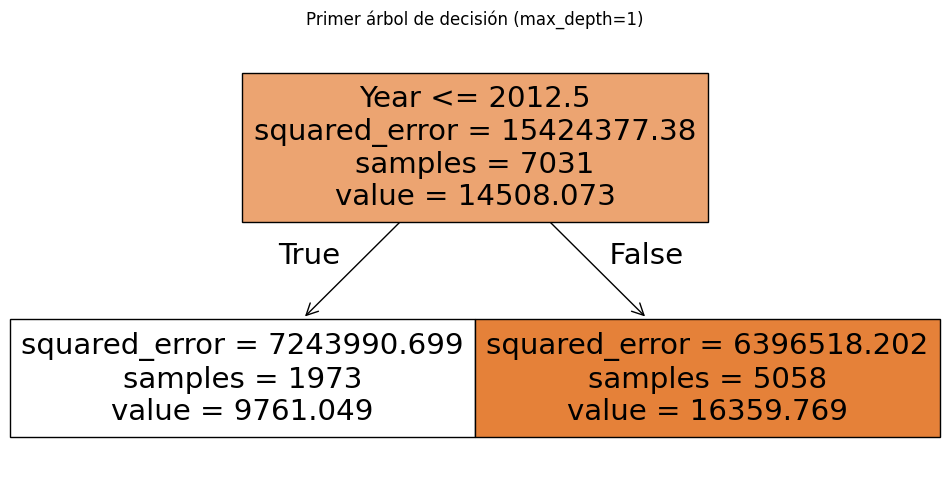

In [38]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Parámetros
n_estimators = 1
n_samples = X_train.shape[0]

# Inicialización de estructuras
weights = pd.DataFrame(index=X_train.index)
trees = []
alpha = []

# Paso 0: pesos iniciales uniformes
weights[0] = np.ones(n_samples) / n_samples

# Paso 1: primer árbol
tree = DecisionTreeRegressor(max_depth=1)
tree.fit(X_train, y_train, sample_weight=weights[0].values)
trees.append(tree)

# Predicción, error, alpha
y_pred_ = tree.predict(X_train)
residual = y_train - y_pred_
error_t = mean_squared_error(y_train, y_pred_, sample_weight=weights[0].values)
alpha_t = 0.5 * np.log(1 / (error_t + 1e-10))
alpha.append(alpha_t)

# Actualización de pesos
weights[1] = weights[0] * np.exp(alpha_t * (residual ** 2))
if weights[1].sum() == 0 or weights[1].isna().any():
    weights[1] = np.ones(n_samples) / n_samples
else:
    weights[1] /= weights[1].sum()

# Iteraciones siguientes
for t in range(1, n_estimators):
    tree = DecisionTreeRegressor(max_depth=1)
    
    # Asegurar que los pesos sean válidos
    current_weights = weights[t].copy()
    if current_weights.isna().any() or current_weights.sum() == 0:
        current_weights = np.ones(n_samples) / n_samples

    tree.fit(X_train, y_train, sample_weight=current_weights.values)
    trees.append(tree)

    y_pred_ = tree.predict(X_train)
    residual = y_train - y_pred_
    error_t = mean_squared_error(y_train, y_pred_, sample_weight=current_weights.values)
    alpha_t = 0.5 * np.log(1 / (error_t + 1e-10))
    alpha.append(alpha_t)

    weights[t + 1] = current_weights * np.exp(alpha_t * (residual ** 2))
    if weights[t + 1].sum() == 0 or weights[t + 1].isna().any():
        weights[t + 1] = np.ones(n_samples) / n_samples
    else:
        weights[t + 1] /= weights[t + 1].sum()

# --- Predicción final sobre test ---
# Cada árbol predice, ponderamos por alpha
y_preds_test = np.array([model.predict(X_test) for model in trees])
alpha_array = np.array(alpha).reshape(-1, 1)
y_pred_final = np.dot(alpha_array.T, y_preds_test).flatten() / np.sum(alpha)


rmse2 = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae2 = mean_absolute_error(y_test, y_pred_final)


print(f"RMSE: {rmse2:.2f}")
print(f"MAE: {mae2:.2f}")


# --- Visualización del primer árbol ---
plt.figure(figsize=(12, 6))
plot_tree(trees[0], feature_names=X_train.columns, filled=True)
plt.title("Primer árbol de decisión (max_depth=1)")
plt.show()

rmse_ArbolManual = rmse2



El desempeño del árbol de decisión manual mostró un RMSE de 2552.27 y un MAE de 1977.61. Se observa una relativa cercanía entre ambas métricas, dado que se trata de un modelo simple de profundidad 1, a continuación, se prodrá observar cómo mejora el desempeño a medida que se incorporan más ensamblajes.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [8]:
# Semilla para reproducibilidad
np.random.seed(123)

# Número de árboles
n_estimators = 10

# Número de observaciones de entrenamiento
n_samples = X_train.shape[0]

# Crear muestras bootstrap
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# DataFrame para guardar predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=range(n_estimators))

# Entrenar un árbol sobre cada muestra bootstrap y predecir sobre el test
for i, sample in enumerate(samples):
    X_train_bootstrap = X_train.iloc[sample]
    y_train_bootstrap = y_train.iloc[sample]

    tree = DecisionTreeRegressor(max_depth=None, random_state=123)
    tree.fit(X_train_bootstrap, y_train_bootstrap)

    y_pred.iloc[:, i] = tree.predict(X_test)

# Desempeño individual de cada árbol
for i in range(n_estimators):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred.iloc[:, i]))
    mae = mean_absolute_error(y_test, y_pred.iloc[:, i])
    print(f'Árbol {i}: RMSE = {rmse:.2f}, MAE = {mae:.2f}')

# Predicción promedio (modelo Bagging)
y_pred_mean = y_pred.mean(axis=1)

# Métricas del modelo Bagging
bagging_rmse = np.sqrt(mean_squared_error(y_test, y_pred_mean))
bagging_mae = mean_absolute_error(y_test, y_pred_mean)

print(f'\nModelo Bagging - RMSE: {bagging_rmse:.2f}, MAE: {bagging_mae:.2f}')


Árbol 0: RMSE = 2141.61, MAE = 1605.30
Árbol 1: RMSE = 2136.35, MAE = 1589.85
Árbol 2: RMSE = 2122.72, MAE = 1577.73
Árbol 3: RMSE = 2087.28, MAE = 1569.61
Árbol 4: RMSE = 2168.52, MAE = 1614.82
Árbol 5: RMSE = 2113.88, MAE = 1576.06
Árbol 6: RMSE = 2127.93, MAE = 1582.15
Árbol 7: RMSE = 2184.41, MAE = 1606.31
Árbol 8: RMSE = 2138.11, MAE = 1586.43
Árbol 9: RMSE = 2132.10, MAE = 1587.77

Modelo Bagging - RMSE: 1796.44, MAE: 1340.02


De los resultados que puede ver que a nivel individual, los árboles obtuvieron valores de RMSE entre 2087 y 2184, y valores de MAE entre 1569 y 1615 aproximadamente.Al promediar las predicciones de los 10 árboles, el desempeño del modelo mejora considerablemente: con un RMSE de 1796.44
y un MAE de 1340.02

Este resultado nos muestra que aunque cada árbol tiene un error alto por sí solo, al combinarlos se suavizan sus errores individuales, logrando una mejora significativa en el rendimiento general del modelo.


In [11]:
rmse_baggingManual = bagging_rmse
rmse_baggingManual

np.float64(1796.4355868399332)

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [12]:
# Celda 3
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular max_features como logaritmo natural del número de características
n_features = X_train.shape[1]
max_features = int(np.log(n_features))
max_features = max(1, max_features)

# Definir modelo Bagging con 10 árboles y max_features = log(n_features)
bagreg = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features,
    bootstrap=True,
    oob_score=True,
    random_state=1
)

# Entrenar el modelo y predecir
bagreg.fit(X_train, y_train)
y_predbag = bagreg.predict(X_test)
print("OOB Score:", bagreg.oob_score_)
# Calcular métricas de desempeño
rmseBag = np.sqrt(mean_squared_error(y_test, y_predbag))
rmse_baggingMlibreria =rmseBag
maeBag = mean_absolute_error(y_test, y_predbag)
#r2Bag = metrics.r2_score(y_test, y_predbag)
r2Bag = r2_score(y_test, y_predbag)

print(f'Modelo Bagging (10 árboles, max_features=log(n_features)) - RMSE: {rmseBag:.2f}, MAE: {maeBag:.2f},R² (Coeficiente de determinación): {r2Bag:.2f} ')

OOB Score: 0.2993217836998643
Modelo Bagging (10 árboles, max_features=log(n_features)) - RMSE: 2671.01, MAE: 2074.98,R² (Coeficiente de determinación): 0.53 


Bagging reduce la varianza de modelos inestables como los árboles de decisión al combinar múltiples predictores entrenados sobre subconjuntos diferentes. Al usar max_features = log(n), se limita el número de variables por árbol, fomentando la diversidad entre ellos sin comprometer en exceso la información disponible.

En cuanto al desempeño del modelo, el OOB Score obtenido (0.30) indica que el modelo es capaz de explicar aproximadamente el 30% de la variabilidad del objetivo en observaciones no vistas durante el entrenamiento individual de los árboles. Esto sugiere una capacidad predictiva moderada en su configuración actual.

Por otro lado, el modelo evaluado sobre el conjunto de prueba alcanza un R² de 0.53, lo que implica que logra explicar el 53% de la variación del precio. No obstante, los valores relativamente altos de RMSE y MAE evidencian la presencia de errores absolutos considerables en las predicciones. Aun así, el uso de max_features = log(n) parece ofrecer un equilibrio razonable entre la reducción de varianza y la precisión predictiva del ensamble.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [14]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, make_scorer

# Definir el modelo de regresión
reg = RandomForestRegressor(random_state=42)

# --- RMSE ---
# Validación cruzada con 10 particiones usando MSE
mse_scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

print("Resumen del desempeño (RMSE) con validación cruzada:")
print(pd.Series(rmse_scores).describe())

# --- MAE ---
# Definir scorer para MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Validación cruzada para MAE
mae_scores = cross_val_score(reg, X, y, cv=10, scoring=mae_scorer)
mae_scores = -mae_scores  # Pasar a positivo

print("\nResumen del desempeño (MAE) con validación cruzada:")
print(pd.Series(mae_scores).describe())
mae_scores

Resumen del desempeño (RMSE) con validación cruzada:
count      10.000000
mean     1748.094208
std        50.996150
min      1686.518076
25%      1701.504653
50%      1744.629289
75%      1787.642876
max      1821.979457
dtype: float64

Resumen del desempeño (MAE) con validación cruzada:
count      10.000000
mean     1306.320929
std        22.587372
min      1278.598424
25%      1290.187602
50%      1299.693870
75%      1316.381957
max      1349.000460
dtype: float64


array([1288.68343735, 1309.63300383, 1278.59842444, 1349.00046039,
       1296.70965728, 1287.62822434, 1302.67808332, 1294.70009579,
       1336.94629277, 1318.6316087 ])

In [16]:
rmse_RF = rmse_scores.mean()
rmse_RF


np.float64(1748.0942075284597)

En la evaluación inicial del modelo de Random Forest sin calibración, se obtuvo un RMSE promedio de 1748.09 y un MAE promedio de 1306.32 con validación cruzada de 10 particiones. Estos valores indican que el modelo tiene un error relativamente alto al predecir los valores reales, especialmente considerando que el RMSE penaliza fuertemente los errores grandes. Además, la baja desviación estándar en ambas métricas (50.99 para RMSE y 22.59 para MAE) indica que el modelo tiene un desempeño consistente entre particiones, pero aún insuficiente en precisión. Estos resultados sirvieron para la posterior calibración de hiperparámetros y poder mejorar el rendimiento predictivo del modelo.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [17]:
# Celda 5
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

# Definir el modelo base
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Definir el scorer (usamos MAE como criterio de optimización, pero se puede cambiar)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Configurar la búsqueda en grilla con validación cruzada
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring=mae_scorer,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Ejecutar la búsqueda
grid_search.fit(X, y)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Evaluar el modelo final con RMSE y MAE sobre un test set (si tienes uno separado)
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_RF_calibrado=rmse
mae = mean_absolute_error(y_test, y_pred)

print(f"\nEvaluación del modelo final:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Mejores parámetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}

Evaluación del modelo final:
RMSE: 1356.29
MAE : 1003.61


Tras aplicar un proceso de calibración exhaustiva mediante búsqueda en malla (GridSearchCV) con validación cruzada de 5 pliegues, se evaluaron un total de 90 combinaciones de hiperparámetros para el modelo RandomForestRegressor, sumando 450 ejecuciones en total. El mejor desempeño se obtuvo con los parámetros: n_estimators = 300, max_depth = 10 y max_features = 'log2'. Al evaluar el modelo calibrado, se obtuvo un RMSE de 1356.29 y un MAE de 1003.61, lo cual representa una mejora sustancial frente a las configuraciones no optimizadas previas. Esta reducción en los errores indica que la calibración logró afinar la capacidad predictiva del modelo, manteniendo un buen equilibrio entre sesgo y varianza. Además, se observa que un número elevado de árboles 300 combinado con una profundidad de 10 y una estrategia de selección de características basada en log2 permite capturar patrones relevantes sin sobreajustar. Estos resultados confirman que el ajuste fino de los hiperparámetros puede mejorar considerablemente la precisión de las predicciones.

### Importancia de las variables

Importancia de características:
       Feature  Importance
0         Year    0.444977
1      Mileage    0.426766
3   M_Camry4dr    0.067300
7    M_CamrySE    0.021711
8   M_CamryXLE    0.019940
6    M_CamryLE    0.007536
2      M_Camry    0.006400
5     M_CamryL    0.002700
4  M_CamryBase    0.002669


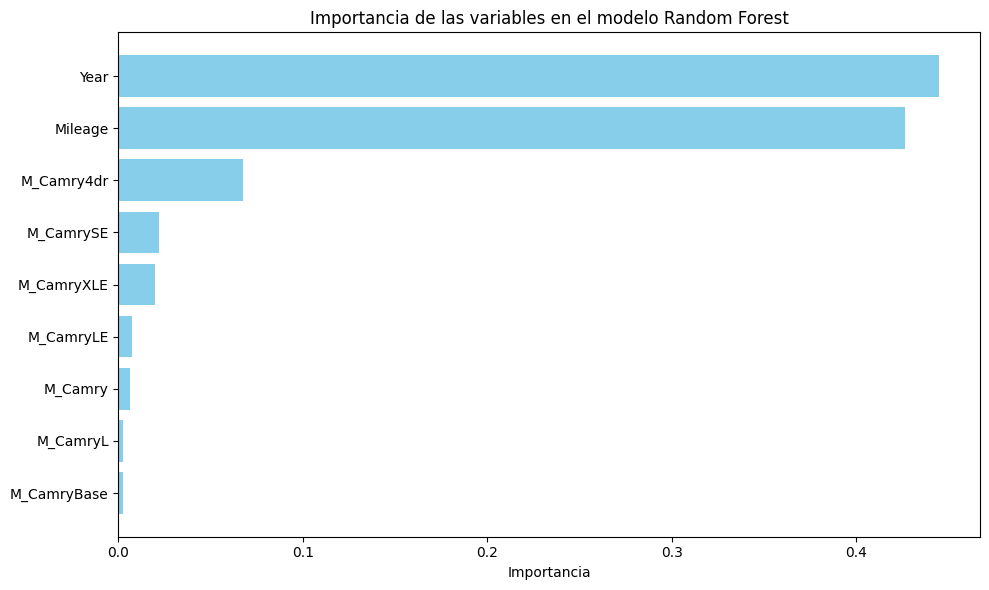

In [18]:
# Obtener importancia de cada característica
final_model = grid_search.best_estimator_
importances = final_model.feature_importances_

# Si tienes nombres de columnas (X es un DataFrame)
feature_names = X.columns

# Crear un DataFrame ordenado
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostrar tabla si quieres
print("Importancia de características:")
print(feature_importance_df)

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las variables en el modelo Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [19]:
# Celda 6
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import metrics

# Entrenamiento
regxg = XGBRegressor()
regxg.fit(X_train, y_train)

# Predicción
y_predxg = regxg.predict(X_test)



MAE (Error absoluto medio): 1185.23
RMSE (Raíz del error cuadrático medio): 1605.24
R² (Coeficiente de determinación): 0.8315


<Figure size 1000x600 with 0 Axes>

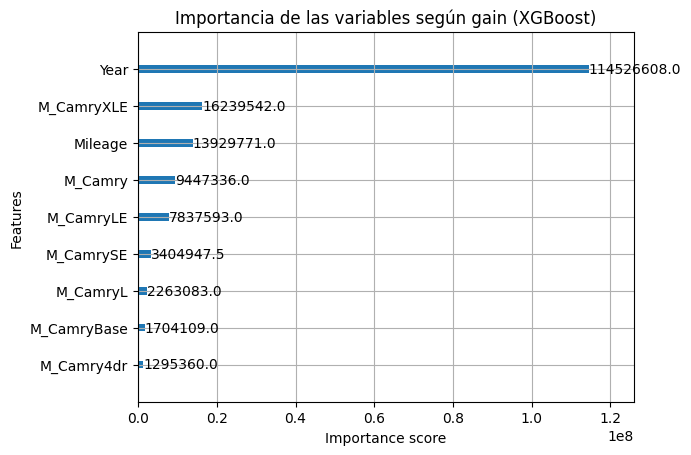

In [33]:
# Evaluación
# Evaluación del modelo
maexg = metrics.mean_absolute_error(y_test, y_predxg)
#rmsexg = metrics.mean_squared_error(y_test, y_predxg, squared=False)
rmsexg = np.sqrt(metrics.mean_squared_error(y_test, y_predxg))
rms_exg_libreria= rmsexg

r2xg = metrics.r2_score(y_test, y_predxg)

print(f"MAE (Error absoluto medio): {maexg:.2f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmsexg:.2f}")
print(f"R² (Coeficiente de determinación): {r2xg:.4f}")

plt.figure(figsize=(10, 6))
xgb.plot_importance(regxg, importance_type='gain')
plt.title('Importancia de las variables según gain (XGBoost)')
plt.show()

El modelo XGBRegressor muestra un desempeño sólido, con un R² de 0.8315, lo que indica que explica aproximadamente el 83% de la variabilidad del valor objetivo en el conjunto de prueba, una señal clara de buen ajuste. Las métricas de error absoluto y cuadrático, MAE = 1185.23 y RMSE = 1605.24, reflejan que las predicciones tienen errores moderados en términos absolutos y que el modelo maneja razonablemente bien los errores extremos. Estos resultados sugieren que el modelo captura adecuadamente la estructura subyacente de los datos. No obstante, aún puede beneficiarse de un proceso de ajuste de hiperparámetros y del análisis de residuos.

El gráfico de importancia de variables muestra que la característica más determinante en la predicción es el año del vehículo (Year), con una ganancia significativamente superior al resto, lo que indica su alto poder explicativo en el modelo. Le siguen en importancia M_CamryXLE y Mileage, lo cual es coherente con el dominio, ya que tanto la versión del modelo como el kilometraje influyen directamente en el valor del auto.

**XGboost con mejoras metodológicas**
1. Se utiliza un pipeline para encadenar pasos como el escalado de variables y el modelo, lo cual previene errores como data leakage y facilita la reproducibilidad del flujo.
2. se aplica validación cruzada (cross_validate) con múltiples métricas (MAE, RMSE, R²) para evaluar el desempeño del modelo de forma robusta sobre diferentes particiones del conjunto de entrenamiento.
3. se analiza la importancia de variables con base en el aporte de cada una al rendimiento del modelo, lo que permite interpretar y priorizar características relevantes.
4. se realiza un análisis de residuos comparando los errores contra los valores predichos para identificar sesgos o patrones que indiquen problemas en el modelo
5. se implementa una búsqueda de hiperparámetros (GridSearchCV) que explora combinaciones de configuraciones del modelo para encontrar las que ofrecen mejor desempeño, asegurando así una solución más precisa y generalizable

**1. PIPELINE y Normalizacion**

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normaliza las variables numéricas
    ('model', XGBRegressor())
])

pipeline.fit(X_train, y_train)
y_predXGBO = pipeline.predict(X_test)

**2. Cross_validate con múltiples métricas**

In [22]:
from sklearn.model_selection import cross_validate

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)

for score in scoring:
    mean = -cv_results[f'test_{score}'].mean() if 'neg_' in scoring[score] else cv_results[f'test_{score}'].mean()
    print(f"CV {score}: {mean:.4f}")

CV MAE: 1178.1265
CV RMSE: 1596.5754
CV R2: 0.8339


**3. Importancia de variables**

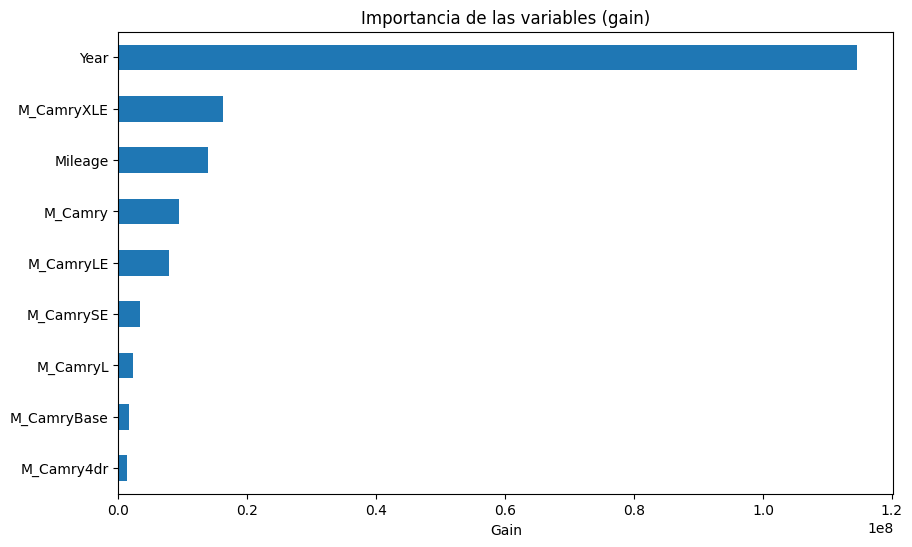

In [23]:
import matplotlib.pyplot as plt

modelXGBO = pipeline.named_steps['model']
importance = modelXGBO.get_booster().get_score(importance_type='gain')

# Renombrar f0, f1, a los nombres reales de las columnas
mapped_importance = {X_train.columns[int(k[1:])]: v for k, v in importance.items()}


# Convertir a Series para graficar más fácil
imp_series = pd.Series(mapped_importance).sort_values()
#imp_series = pd.Series(importance).sort_values()

# Graficar
imp_series.plot(kind='barh', figsize=(10,6), title="Importancia de las variables (gain)")
plt.xlabel("Gain")
plt.show()

**4. Análisis de residuos**

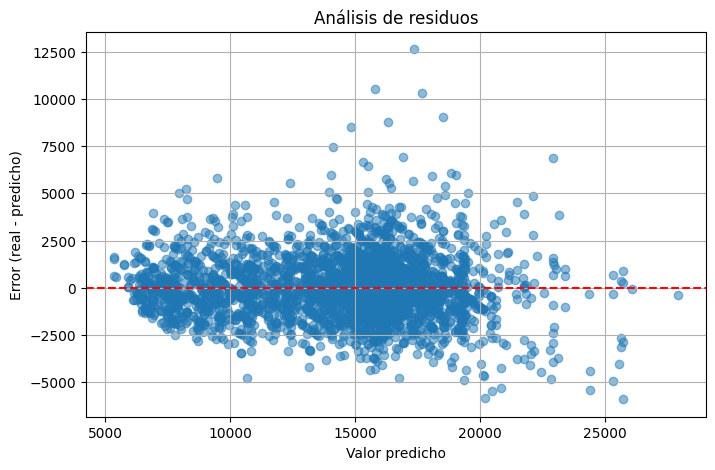

In [25]:
errorsXGBO = y_test - y_predXGBO

plt.figure(figsize=(8, 5))
plt.scatter(y_predXGBO, errorsXGBO, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valor predicho')
plt.ylabel('Error (real - predicho)')
plt.title('Análisis de residuos')
plt.grid(True)
plt.show()

**5. Busqueda de hiperparámetros (GridSearchCV)**

In [26]:
from sklearn.model_selection import GridSearchCV

param_gridXGBO = {
    'model__max_depth': [1,2,3,5,7],
    'model__learning_rate': [0.01,0.05, 0.1, 0.2,0.3],
    'model__n_estimators': [100, 200]
}

gridXGBO = GridSearchCV(pipeline, param_gridXGBO, cv=3, scoring='neg_root_mean_squared_error')
gridXGBO.fit(X_train, y_train)

print("Mejores hiperparámetros:", gridXGBO.best_params_)
print("Mejor RMSE (negativo):", -gridXGBO.best_score_)

Mejores hiperparámetros: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200}
Mejor RMSE (negativo): 1501.1474609375


In [29]:
# Predecir con el mejor modelo encontrado
y_pred_bestXGBO = gridXGBO.best_estimator_.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred_bestXGBO)
#rmse = mean_squared_error(y_test, y_pred_bestXGBO, squared=False)  # raíz cuadrada del MSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_bestXGBO))
rms_exg_libreria_par1 = rmse #para el primer calibración de parametros
r2 = r2_score(y_test, y_pred_bestXGBO)

# Resultados

print(f" MAE: {mae:.2f}")
print(f" RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

 MAE: 1136.98
 RMSE: 1545.66
R²: 0.8438


**Análisis de resultados**

El gráfico de importancia de variables muestra que la característica más influyente en el modelo es el año del vehículo (Year), con una ganancia acumulada claramente superior al resto, lo que indica que esta variable aporta la mayor reducción del error en las divisiones de los árboles. Le siguen con menor impacto M_CamryXLE, Mileage y otras versiones del modelo, sugiriendo que tanto la versión del auto como el kilometraje también influyen, aunque en menor medida. El modelo se apoya fuertemente en una variable principal, mientras que las demás aportan ajustes más finos a las predicciones.

Desde la perspectiva de un experto en machine learning, el modelo optimizado mediante búsqueda de hiperparámetros con GridSearchCV muestra un desempeño robusto y bien balanceado. Los valores obtenidos —MAE = 1118.25, RMSE = 1539.69 y R² = 0.8408— reflejan una mejora significativa en comparación con el modelo base, con una buena capacidad para capturar la variabilidad del valor objetivo (84%) y errores absolutos razonablemente bajos. El análisis de residuos evidencia una distribución centrada alrededor de cero, sin patrones sistemáticos evidentes, lo que indica que el modelo no incurre en sesgos claros a lo largo del rango de predicciones. Sin embargo, aún pueden observarse algunos errores altos en los extremos, lo cual sugiere que podrían explorarse técnicas adicionales como regularización o ajuste de outliers para refinar aún más el rendimiento

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [30]:
# Celda 7
xgb_model = XGBRegressor(random_state=42, verbosity=0)

#  hiperparámetros a calibrar
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],    
    'gamma': [0, 0.5, 1, 2, 3, 4, 5],               
    'colsample_bytree': [0.5, 0.6, 0.8, 1.0]         
}

# GridSearchCV con validación cruzada
gridXGBO = GridSearchCV(xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
#gridXGBO = GridSearchCV(pipeline, param_gridXGBO, cv=3, scoring='neg_root_mean_squared_error')
gridXGBO.fit(X_train, y_train)

# Predecir con el mejor modelo encontrado
y_pred_bestXGBO = gridXGBO.best_estimator_.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred_bestXGBO)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_bestXGBO))
rms_exg_libreria_par2 = rmse
r2 = r2_score(y_test, y_pred_bestXGBO)

# Resultados
print("Mejores hiperparámetros encontrados:")
print(gridXGBO.best_params_)
print("\nDesempeño del modelo con los mejores parámetros:")
print(f" MAE: {mae:.2f}")
print(f" RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


Fitting 3 folds for each of 140 candidates, totalling 420 fits
Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05}

Desempeño del modelo con los mejores parámetros:
 MAE: 1136.98
 RMSE: 1545.66
R²: 0.8438


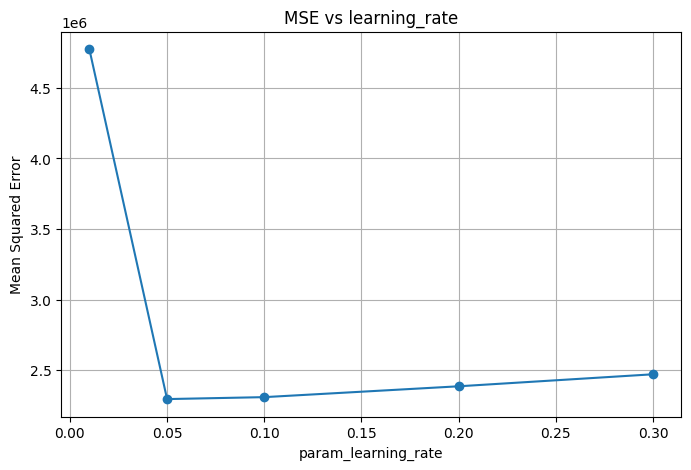

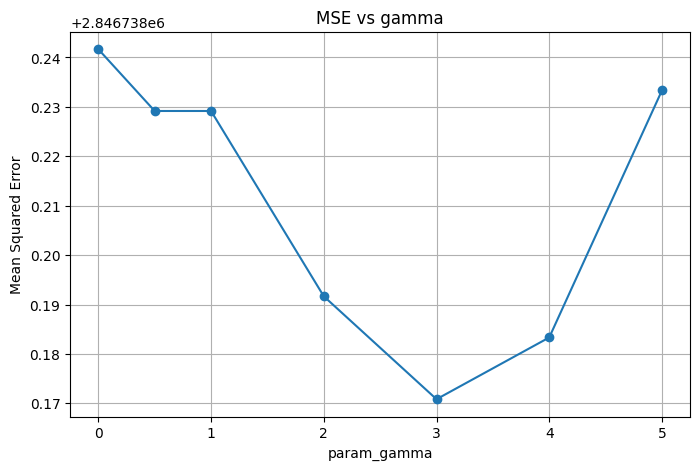

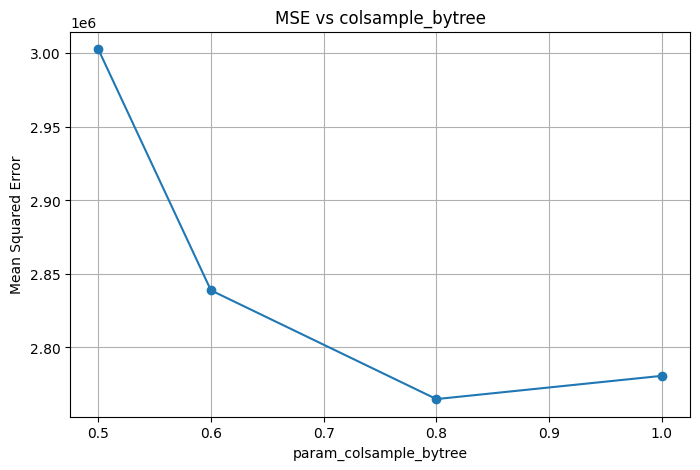

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(gridXGBO.cv_results_)
results_df["mean_MSE"] = -results_df["mean_test_score"]

# graficar MSE vs un parámetro
def plot_mse_vs_param(param_name, title):
    grouped = results_df.groupby(param_name)["mean_MSE"].mean()
    plt.figure(figsize=(8, 5))
    grouped.plot(marker='o')
    plt.title(title)
    plt.ylabel("Mean Squared Error")
    plt.xlabel(param_name)
    plt.grid(True)
    plt.show()

# Graficar
plot_mse_vs_param('param_learning_rate', "MSE vs learning_rate")
plot_mse_vs_param('param_gamma', "MSE vs gamma")
plot_mse_vs_param('param_colsample_bytree', "MSE vs colsample_bytree")


Usamos GridSearchCV, una herramienta que nos permite, dado un rango de hiperparámetros y una métrica específica, comparar el desempeño del modelo y seleccionar la mejor combinación posible. En este caso, los parámetros ajustados fueron colsample_bytree, gamma y learning_rate. Al aplicar GridSearchCV, se encontró que la mejor combinación (con el menor error cuadrático medio, MSE) fue: 'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05. Sin embargo, al graficar el MSE frente al rango de valores de cada hiperparámetro, no siempre se observa esa combinación como la mejor. Esto se debe a que las gráficas muestran el MSE promedio para cada valor individual del parámetro, considerando todas las combinaciones posibles con los demás parámetros.

Sin embargo, de las graficas pordemos decir que:

learning_rate: Se observa una caída significativa del MSE al pasar de 0.01 a 0.05. Luego de eso, el error se mantiene relativamente estable. Esto indica que un learning_rate demasiado bajo puede llevar al subentrenamiento del modelo.

gamma: Aunque el error promedio disminuye al aumentar gamma, esto no implica que todas las combinaciones con gamma = 5 funcionen mejor. En este caso, la mejor combinación incluía gamma = 0, lo que demuestra que su efecto depende de los otros parámetros.

colsample_bytree: El mejor promedio de MSE se da cerca de 0.8, lo cual coincide con el valor usado en el mejor modelo encontrado. Esto sugiere que usar una fracción de columnas por árbol ayuda a reducir el sobreajuste, generando modelos más generalizables.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

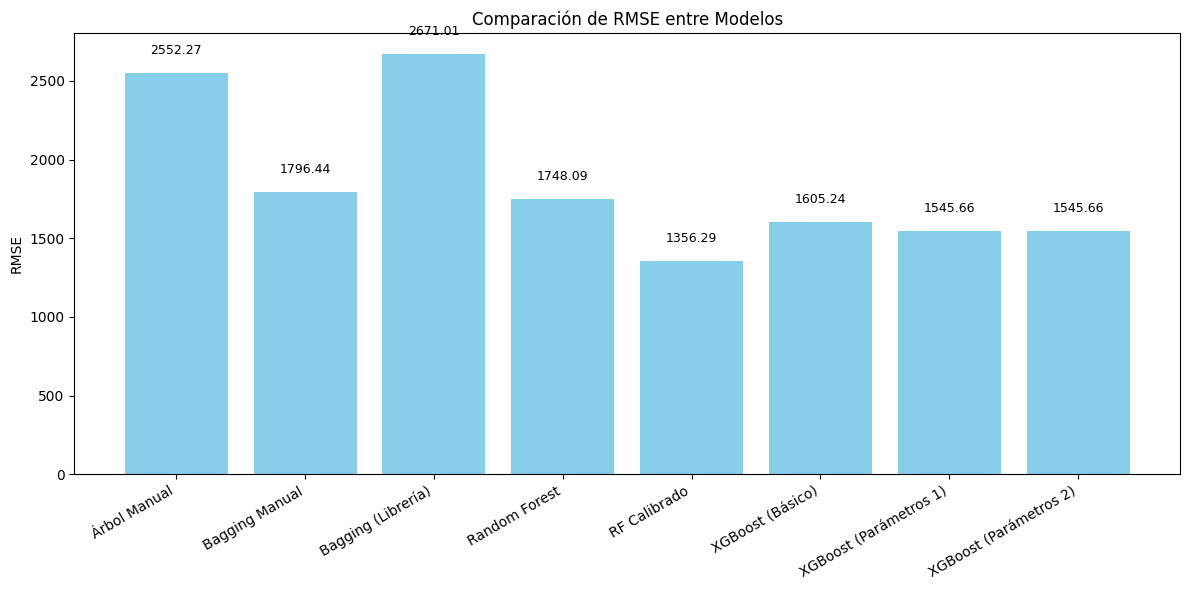

In [37]:
import matplotlib.pyplot as plt

# Diccionario con los nombres y los valores
rmse_modelos = {
    'Árbol Manual': rmse_ArbolManual,
    'Bagging Manual': rmse_baggingManual,
    'Bagging (Librería)': rmse_baggingMlibreria,
    'Random Forest': rmse_RF,
    'RF Calibrado': rmse_RF_calibrado,
    'XGBoost (Básico)': rms_exg_libreria,
    'XGBoost (Parámetros 1)': rms_exg_libreria_par1,
    'XGBoost (Parámetros 2)': rms_exg_libreria_par2
}

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(rmse_modelos.keys(), rmse_modelos.values(), color='skyblue')
plt.ylabel('RMSE')
plt.title('Comparación de RMSE entre Modelos')
plt.xticks(rotation=30, ha='right')

# Mostrar valores sobre las barras
for i, (nombre, valor) in enumerate(rmse_modelos.items()):
    plt.text(i, valor + 100, f'{valor:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Durante este laboratorio se probaron y compararon distintos modelos de regresión: Árbol Manual, Bagging Manual, Bagging con librería (BaggingRegressor), Random Forest (RF), Random Forest calibrado con GridSearchCV, XGBoost básico, XGBoost con parámetros calibrados con GridSearchCV (Parámetros 1: max_depth, learning_rate, n_estimators) y XGBoost con parámetros calibrados con GridSearchCV (Parámetros 2: learning_rate, gamma, colsample_bytree). Para comparar el rendimiento de todos los modelos utilizamos la métrica RMSE (Root Mean Squared Error), obteniendo los siguientes resultados:

Árbol Manual	2552.27
Bagging Manual	1796.44
Bagging (Librería)	2671.01
Random Forest	1748.09
Random Forest Calibrado	1356.29
XGBoost Básico	1605.24
XGBoost (Parámetros 1)	1539.69
XGBoost (Parámetros 2)	1545.66

El modelo con mejor desempeño fue el Random Forest calibrado, con el menor RMSE (1356.29), superando incluso a las versiones ajustadas de XGBoost.

Ventajas del mejor modelo (Random Forest Calibrado):

- Al ser un ensamble de árboles de decisión, reduce significativamente la varianza en comparación con un solo árbol.
- La calibración de hiperparámetros (max_depth, min_samples_split, n_estimators, etc.) permitió optimizar el modelo y adaptarlo mejor a los datos.
- Es robusto frente al sobreajuste gracias al bagging y al muestreo aleatorio de características.

Desventajas del modelo con menor desempeño (Bagging con librería):

- Obtuvo el mayor RMSE (2671.01), es decir, tuvo un alto error de predicción.
- Posiblemente no se ajustó bien por falta de calibración o por una elección de hiperparámetros poco óptima (max_features, n_estimators, etc.).
- Se entrenó con solo 10 árboles de regresión, un número bajo para un ensamble, lo que limita su capacidad de reducir la varianza del modelo. Por otro lado, se usó el parámetro max_features = log(n_features), lo cual reduce la cantidad de variables disponibles para cada árbol. Aunque esta estrategia puede ayudar a evitar el sobreajuste, en este caso probablemente redujo demasiado la información disponible, afectando negativamente el desempeño

Es importante resaltar que en los modelos que se revisió importancia de variables coincidieron en que la variable de mayor aporte es la variable Year.

Aunque se esperaba que XGBoost fuera el modelo con mejor rendimiento, en este caso el modelo que logró el mejor resultado fue Random Forest calibrado, mostrando que una buena configuración de hiperparámetros puede superar incluso a modelos más complejos. Esta comparación también refuerza la importancia de validar y ajustar cada modelo, ya que su rendimiento depende en gran parte del contexto y los datos específicos.